# Cross Validation

먼저 교차검증(Cross Validation)이란 무엇인지 알아보겠습니다.

보통 모델링을 하는 과정에서 저희는 주어진 train set을 학습을 위한 train set과 학습된 모델의 성능을 검증하기 위한 test set으로 분리합니다.

train set을 이용해 만든 모델이 새로운 데이터에서도 잘 작동할 수 있는지를 확인하는 과정이죠.

그러나, 이러한 방법에는 약점이 존재합니다.

첫째, 고정된 test set을 사용해 계속해서 모델 성능을 검증/수정하다 보면 결국 이 모델은 본인이 설정한 test set에만 잘 작동하는 모델이 되는 것입니다.

일반적인 설명력을 갖는 것이 아니라 특정 일부 데이터에만 최적화되이것은 다른 말로 test set에 과적합(overfitting)되었다고 표현합니다.

제가 만든 test set에 과적합된 모델을 다른 데이터에 적용했을 경우 성능이 떨어지게 되는 것이죠.

둘째, 모델 학습에 사용할 수 있는 데이터의 양이 줄어듭니다.

따로 떼어놓은 test set은 아예 학습에 사용할 수 없기 때문입니다.

따라서 이러한 문제를 해결하고자 교차검증(Cross Validation)을 사용할 수 있습니다.

교차검증은 train set을 train set과 validation set으로 분리하여 train set으로 학습된 모델을 validation set을 통해 검증하는 방식입니다.!

# K-Fold Cross Validation

자 그렇다면 K-Fold란 무슨 뜻일까요?

K-Fold(K-겹 교차검증)는 가장 일반적으로 사용되는 교차 검증 방법으로, 회귀 모델에 많이 사용됩니다.

간단하게는 교차 검증을 K번 진행한다고 생각하시면 될 것 같습니다.

자세한 과정을 살펴보면 다음과 같습니다.

**[K-Fold Cross Validation]**

1.전체 데이터셋을 Training Set과 Test Set으로 나눕니다.

2.Training Set를 k개의 폴드(부분)로 나눕니다.

3.첫 번째 폴드를 Validation Set으로 사용하고 나머지 폴드들을 Training Set으로 사용합니다.

4.모델을 Training한 뒤, 첫 번 째 Validation Set으로 평가합니다.

5.차례대로 다음 폴드를 Validation Set으로 사용하며 K번을 반복합니다.
결과적으로 총 k개의 성능 결과를 얻게 되면, 모델의 성능은 각 결과값들의 평균으로 정해집니다.

하단 이미지는 5개의 fold를 사용한 Cross Validation 과정을 보여줍니다.

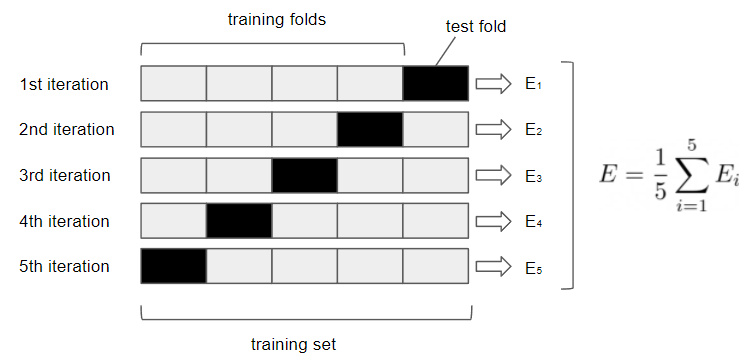

하나의 데이터셋을 가지고 모든 데이터를 적어도 한번은 학습에 활용하며 K번의 검증 과정을 거칠 수 있습니다. 이제 애플 주식 데이터를 선형회귀 모델로 예측해보는 실습을 통해 내용을 적용해봅시다.

# 애플 주식 가격 예측 실습

## 데이터 전처리 및 시각화

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
import numpy as np
import warnings

# 특정 경고 메시지를 무시
warnings.filterwarnings("ignore")

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_selection import RFECV, SelectFromModel, SelectKBest
from sklearn import metrics
%matplotlib inline

In [4]:
Stock = pd.read_csv('./AAPL.csv',  index_col=0)

In [18]:
df_Stock = Stock
df_Stock = df_Stock.rename(columns={'Close(t)':'Close'})
df_Stock.head()

,Open,High,Low,Close,Volume,SD20,Upper_Band,Lower_Band,S_Close(t-1),S_Close(t-2),...,QQQ_MA10,QQQ_MA20,QQQ_MA50,SnP_Close,SnP(t-1)),SnP(t-5),DJIA_Close,DJIA(t-1)),DJIA(t-5),Close_forcast
Date,,,,,,,,,,,,,,,,,,,,,
2005-10-17,6.66,6.69,6.50,6.60,154208600,0.169237,6.827473,6.150527,6.67,6.63,...,33.692,33.9970,34.2690,1190.10,1186.57,1187.33,10348.10,10287.34,10238.76,6.45
2005-10-18,6.57,6.66,6.44,6.45,152397000,0.168339,6.819677,6.146323,6.60,6.67,...,33.570,33.9525,34.2466,1178.14,1190.10,1184.87,10285.26,10348.10,10253.17,6.78
2005-10-19,6.43,6.78,6.32,6.78,252170800,0.180306,6.861112,6.139888,6.45,6.60,...,33.562,33.9600,34.2330,1195.76,1178.14,1177.68,10414.13,10285.26,10216.91,6.93
2005-10-20,6.72,6.97,6.71,6.93,339440500,0.202674,6.931847,6.121153,6.78,6.45,...,33.567,33.9455,34.2190,1177.80,1195.76,1176.84,10281.10,10414.13,10216.59,6.87
2005-10-21,7.02,7.03,6.83,6.87,199181500,0.216680,6.974860,6.108140,6.93,6.78,...,33.586,33.9365,34.2034,1179.59,1177.80,1186.57,10215.22,10281.10,10287.34,7.01


In [6]:
df_Stock.shape

(3732, 63)

In [20]:
df_Stock = df_Stock.drop(columns='Date_col')

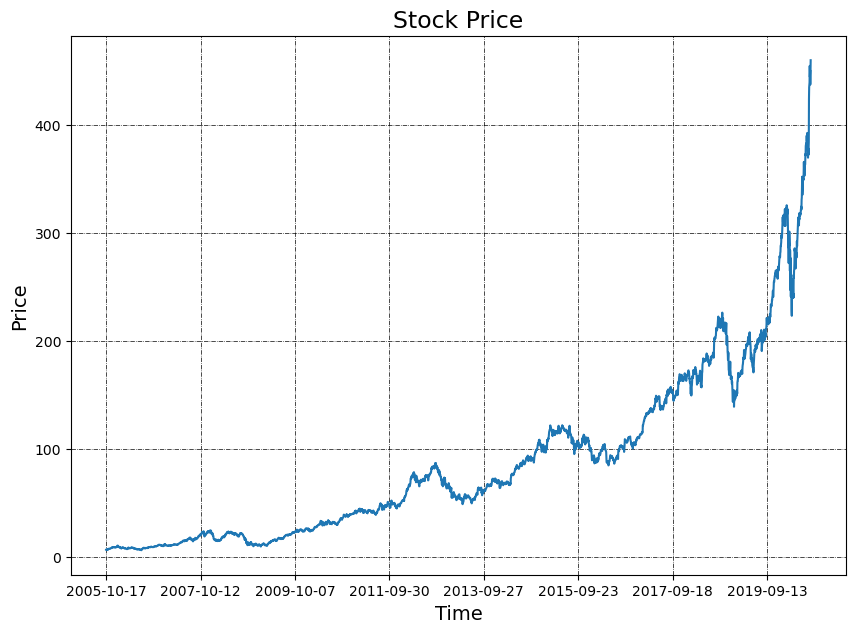

In [21]:
df_Stock['Close'].plot(figsize=(10, 7))
plt.title("Stock Price", fontsize=17)
plt.ylabel('Price', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
plt.show()

## 과제 1번

해당 함수에서 설정한 훈련 세트, 검증 세트, 테스트 세트의 비율을 적어주세요

정답: 훈련세트 88%, 검증 세트 10%, 테스트 세트 2%

In [24]:
def create_train_test_set(df_Stock):
    
    features = df_Stock.drop(columns=['Close_forcast'], axis=1) #'Close_forcast'열을 제외한 데이터셋: features
    target = df_Stock['Close_forcast'] #'Close_forcast'열만 있는 데이터셋: target
    

    data_len = df_Stock.shape[0] #shape는 데이터셋의 (행 개수, 열 개수)를 반환 -> shape[0]은 '행 개수'를 의미
    print('Historical Stock Data length is - ', str(data_len))

    #create a chronological split for train and testing
    train_split = int(data_len * 0.88) #데이터셋의 88%는 훈련세트에 배당
    print('Training Set length - ', str(train_split))

    val_split = train_split + int(data_len * 0.1) #데이터*88% + 데이터*10%
    print('Validation Set length - ', str(int(data_len * 0.1))) #데이터셋의 10%는 검증세트에 배당

    print('Test Set length - ', str(int(data_len * 0.02))) #데이터셋의 2%는 테스트세트에 배당

    # Splitting features and target into train, validation and test samples 
    X_train, X_val, X_test = features[:train_split], features[train_split:val_split], features[val_split:]
    Y_train, Y_val, Y_test = target[:train_split], target[train_split:val_split], target[val_split:]

    #print shape of samples
    print(X_train.shape, X_val.shape, X_test.shape)
    print(Y_train.shape, Y_val.shape, Y_test.shape)
    
    return X_train, X_val, X_test, Y_train, Y_val, Y_test

In [25]:
X_train, X_val, X_test, Y_train, Y_val, Y_test = create_train_test_set(df_Stock)

Historical Stock Data length is -  3732
Training Set length -  3284
Validation Set length -  373
Test Set length -  74
(3284, 61) (373, 61) (75, 61)
(3284,) (373,) (75,)


## K-FOLD Cross Validation

In [26]:
features = df_Stock.drop(columns=['Close_forcast'], axis=1)
target = df_Stock['Close_forcast']

In [27]:
X_train, X_test, Y_train, Y_test = train_test_split(features, target, test_size=0.2, random_state=42)
#train_test_split함수는 scikit-learn 라이브러리에서 제공되며, 주어진 데이터를 훈련 세트와 테스트 세트로 무작위로 분할한다.
#features: 독립변수, target: 종속변수, test_size: 테스트세트의 크기, random_state: 42를 시드값으로 갖는 난수 생성

In [28]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
# K-Fold 교차 검증을 설정합니다.
n_splits = 5  # 분할할 폴드의 수
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
#shuffle=True: 데이터를 분할하기 전에 데이터를 무작위로 섞습니다.
#이것은 데이터의 순서에 편향이 있을 경우(예: 정렬된 데이터) 유용하며, 각 폴드가 데이터의 무작위 샘플을 반영하도록 합니다.

# 모델을 초기화합니다. 원하는 모델로 대체 가능합니다.
model = LinearRegression()

# 폴드별 성능을 저장할 리스트를 초기화합니다.
train_scores, val_scores = [], []

## 과제 2번
아래 K-Fold 교차 검증을 통해 도출된 RMSE 값을 바탕으로 해당 모델의 성능을 수치로 표현하세요. (힌트 상단 설명)

정답: (2.35+2.69+2.34+2.58+3.35)/5 = 2.662

In [33]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# 데이터를 특성(features)과 타겟(target)으로 나눕니다.
features = df_Stock.drop(columns=['Close_forcast'], axis=1)
target = df_Stock['Close_forcast']

# K-Fold 교차 검증을 설정합니다.
n_splits = 5  # 분할할 폴드의 수
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# 모델을 초기화합니다. 원하는 모델로 대체 가능합니다.
model = LinearRegression()

# 폴드별 성능 및 데이터 크기를 저장할 리스트를 초기화합니다.
rmse_scores = []
train_sizes, val_sizes = [], []

# K-Fold 교차 검증 반복
for fold_idx, (train_idx, val_idx) in enumerate(kf.split(features)): 
    #독립변수인 features에서 split
    #enumerate는 반복되는 폴드의 인덱스와 함께 훈련 및 검증 인덱스를 제공
    #fold_idx는 현재 폴드의 번호(예: 0, 1, 2, ...)
    #train_idx와 val_idx는 각각 현재 폴드에서 사용될 훈련 및 검증 데이터의 인덱스
    
    X_train_fold, X_val_fold = features.iloc[train_idx], features.iloc[val_idx]
    Y_train_fold, Y_val_fold = target.iloc[train_idx], target.iloc[val_idx]

    # 모델을 훈련하고 검증합니다.
    model.fit(X_train_fold, Y_train_fold)
    Y_val_pred = model.predict(X_val_fold)

    # 검증 데이터의 RMSE 계산
    rmse = np.sqrt(mean_squared_error(Y_val_fold, Y_val_pred))
    rmse_scores.append(rmse)

    # 훈련 데이터 및 검증 데이터 크기 저장
    train_sizes.append(len(train_idx))
    val_sizes.append(len(val_idx))

    # 결과 출력
    print(f"{fold_idx + 1}번째 교차 검증 RMSE: {rmse:.2f}, 학습 데이터 크기: {len(train_idx)}, 검증 데이터 크기: {len(val_idx)}")


1번째 교차 검증 RMSE: 2.35, 학습 데이터 크기: 2985, 검증 데이터 크기: 747
2번째 교차 검증 RMSE: 2.69, 학습 데이터 크기: 2985, 검증 데이터 크기: 747
3번째 교차 검증 RMSE: 2.34, 학습 데이터 크기: 2986, 검증 데이터 크기: 746
4번째 교차 검증 RMSE: 2.58, 학습 데이터 크기: 2986, 검증 데이터 크기: 746
5번째 교차 검증 RMSE: 3.35, 학습 데이터 크기: 2986, 검증 데이터 크기: 746


In [29]:
print('LR Coefficients: \n', model.coef_)
print('LR Intercept: \n', model.intercept_)

AttributeError: 'LinearRegression' object has no attribute 'coef_'

# Predict for the test dataset

## 과제 3

**** 을 채워주세요

In [34]:
Y_test_pred = model.predict(X_test)

In [35]:
print("Test R-squared: ",round(metrics.r2_score(Y_test,Y_test_pred),2))
print("Test Explained Variation: ",round(metrics.explained_variance_score(Y_test,Y_test_pred),2)) 
print('Test Mean Squared Error:', round(metrics.mean_squared_error(Y_test,Y_test_pred), 2)) 
print("Test RMSE: ",round(np.sqrt(metrics.mean_squared_error(Y_test,Y_test_pred)),2))
print("Test MAE: ",round(metrics.mean_absolute_error(Y_test,Y_test_pred),2))

Test R-squared:  1.0
Test Explained Variation:  1.0
Test Mean Squared Error: 3.75
Test RMSE:  1.94
Test MAE:  1.01


In [40]:
df_pred = pd.DataFrame(Y_test.values, columns=['Actual'], index=Y_test.index)
df_pred['Predicted'] = Y_test_pred
df_pred = df_pred.reset_index()
df_pred.loc[:, 'Date'] = pd.to_datetime(df_pred['Date'],format='%Y-%m-%d')
df_pred

,Date,Actual,Predicted
0,2017-03-10 00:00:00,132.63,132.606660
1,2015-09-21 00:00:00,104.79,106.624711
2,2012-06-14 00:00:00,70.88,70.079031
3,2012-05-09 00:00:00,70.43,69.946431
4,2007-05-03 00:00:00,12.44,12.402035
...,...,...,...
742,2017-02-21 00:00:00,130.64,130.367844
743,2018-11-05 00:00:00,198.68,198.189345
744,2019-09-17 00:00:00,220.58,218.439568
745,2006-10-25 00:00:00,10.15,10.199807


<Axes: >

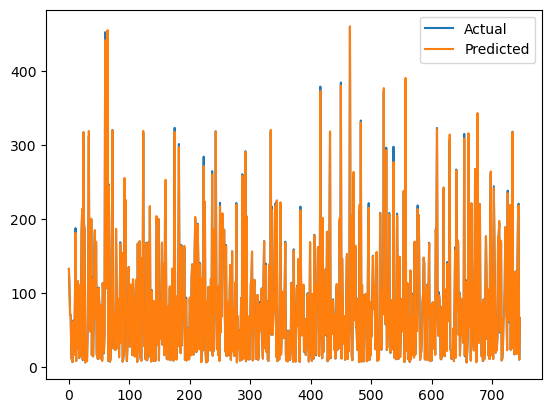

In [37]:
df_pred[['Actual', 'Predicted']].plot()